# Filtering internal tide modes 

This notebook aims at filtering Internal Tide modes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
import scipy.fftpack as fp
from scipy.interpolate import RegularGridInterpolator, griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from math import *
from dask import delayed,compute
from joblib import Parallel
from joblib import delayed as jb_delayed


## 0. - Parameters 
* **date** : date of dataset to filter 
* **lon_min**, **lon_max**, **lat_min**, **lat_max** : region limits 
* **n_workers** : number of cpus 

In [2]:
date = "20120605"
lon_min=360-130; lon_max=360-120; lat_min=30;lat_max=40
n_workers = 24

Regional limits for following zones are : 
* **Hawai** : lon_min=185;lon_max=205;lat_min=30;lat_max=40;
* **CCS** : lon_min=360-130; lon_max=360-120; lat_min=30;lat_max=40

## 1. - Data import 

Mask is imported from **"/bettik/bellemva/MITgcm/mask/mask.nc"**.

In [3]:
mask = xr.open_dataset("/bettik/bellemva/MITgcm/mask/mask.nc")

The Dataset of all SSH variables is loaded with xarray.

In [4]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+date+".nc")

A DataArray is created with Internal Tide (IT). Region of Hawai'i is selected. 

In [5]:
ssh_it = ds.ssh_it.sel(longitude = slice(lon_min,lon_max),latitude=slice(lat_min,lat_max),drop=True)
ssh_it = ssh_it.load().chunk({'time':1})

## 2. - Data processing 

The HF SSH needs to be processed before barotropic tide is removed. First of all, NaNs are filled by interpolation. 

In [6]:
x_axis = Axis(ssh_it.longitude.values,is_circle=True)
y_axis = Axis(ssh_it.latitude.values,is_circle=True)
t_axis = TemporalAxis(ssh_it.time.values)

grid = Grid3D(y_axis, x_axis, t_axis, ssh_it.values.transpose(1,2,0))
has_converged, filled = fill.gauss_seidel(grid,num_threads=24)

ssh_it_filled = ssh_it.copy(deep=True,data=filled.transpose(2,0,1)).chunk({'time':1})


The filled SSH is interpolated on a cartesian grid (regular in distance). Two empty bands of NaNs are situated on each side of the region. They are filled with interpolation. 

In [15]:
dx = 2 # in kilometers, spacing of the grid 

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_it_filled.latitude.values,
                                                         ssh_it_filled.longitude.values,
                                                         dx)

array_cart_ssh = ssh_it_filled.interp(latitude=('z',ENSLAT2D.flatten()),
                                      longitude=('z',ENSLON2D.flatten()),
                                     ).values

# INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
t_axis = TemporalAxis(ssh_it.time.values)

grid = Grid3D(y_axis, x_axis, t_axis, array_cart_ssh.reshape((24,i_lat,i_lon)).transpose(1,2,0))
has_converged, filled = fill.gauss_seidel(grid,num_threads=4)

mask_cart = np.isnan(array_cart_ssh[0].reshape((i_lat,i_lon)))

# CREATION OF DataArray #
cart_ssh_it = xr.DataArray(data=filled.transpose(2,0,1),
                          dims=["time","y","x"],
                          coords = dict(
                              time = ssh_it_filled.time.values,
                              y=(["y"],np.array([i*dx for i in range (i_lat)])),
                              x=(["x"],np.array([i*dx for i in range (i_lon)]))
                          )).chunk({'time':1})

## 3. - Extracting Internal Tide modes 

The internal tide modes are extracted with the function **extract_it_mode**. Joblib delayed package is used for parellizing over the time steps. 

In [16]:
# PARAMETERS FOR THE FUNCTION # 
k1 = 0.0070
k2 = 0.0126
k3 = 0.0191
k4 = 0.0269

nx = i_lon
ny = i_lat

kx = np.fft.fftfreq(3*nx,dx) # km
ky = np.fft.fftfreq(3*ny,dx) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2)

wavenumbers_mode_1 = [0.5*k1,0.5*(k1+k2)] # in km
wavenumbers_mode_2 = [0.5*(k1+k2),0.5*(k2+k3)] # in km
wavenumbers_mode_3 = [0.5*(k2+k3),0.5*(k3+k4)] # in km

bandpass_mode_1 = bandpass(wavenumbers = wavenumbers_mode_1)
bandpass_mode_2 = bandpass(wavenumbers = wavenumbers_mode_2)
bandpass_mode_3 = bandpass(wavenumbers = wavenumbers_mode_3)

In [17]:
window = create_spatial_window(nx=i_lon, ny=i_lat)

cart_modes_it = np.array(Parallel(n_jobs=4,backend='multiprocessing')(jb_delayed(extract_it_mode)(cart_ssh_it[i].values,dx,window) for i in range(24)))
cart_modes_it = cart_modes_it.transpose((1,0,2,3))

cart_it_1 = cart_modes_it[0]
cart_it_2 = cart_modes_it[1]
cart_it_3 = cart_modes_it[2]


The values are interpolated into a geodesic grid : 

In [18]:
lon2d, lat2d = np.meshgrid(ssh_it.longitude.values, ssh_it.latitude.values)

tri = Delaunay(np.array([ENSLAT2D.flatten(),ENSLON2D.flatten()]).T)  # Compute the triangulation

interpolator_mode1 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(LinearNDInterpolator)(tri, cart_it_1[i].flatten()) for i in range (24)))
interpolator_mode2 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(LinearNDInterpolator)(tri, cart_it_2[i].flatten()) for i in range (24)))
interpolator_mode3 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(LinearNDInterpolator)(tri, cart_it_3[i].flatten()) for i in range (24)))

geo_it1 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(interpolator_mode1[i])(np.array([lat2d.flatten(),lon2d.flatten()]).T) for i in range (24)))
geo_it1 = geo_it1.reshape(24,lat2d.shape[0],lat2d.shape[1])

geo_it2 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(interpolator_mode2[i])(np.array([lat2d.flatten(),lon2d.flatten()]).T) for i in range (24)))
geo_it2 = geo_it2.reshape(24,lat2d.shape[0],lat2d.shape[1])

geo_it3 = np.array(Parallel(n_jobs=n_workers,backend='multiprocessing')(jb_delayed(interpolator_mode3[i])(np.array([lat2d.flatten(),lon2d.flatten()]).T) for i in range (24)))
geo_it3 = geo_it1.reshape(24,lat2d.shape[0],lat2d.shape[1])

DataArray object is created for each time step : 

In [19]:
ssh_it1 = ssh_it.copy(deep=True,data=geo_it1).chunk({'time':1})
ssh_it2 = ssh_it.copy(deep=True,data=geo_it2).chunk({'time':1})
ssh_it3 = ssh_it.copy(deep=True,data=geo_it3).chunk({'time':1})


Coast values are masked : 

In [21]:
mask = xr.open_dataset("/bettik/bellemva/MITgcm/mask/mask.nc").sel(longitude = slice(lon_min,lon_max),latitude=slice(lat_min,lat_max),drop=True).mask.values

ssh_it1 = ssh_it1.where(mask==False,np.nan)
ssh_it2 = ssh_it2.where(mask==False,np.nan)
ssh_it3 = ssh_it3.where(mask==False,np.nan)

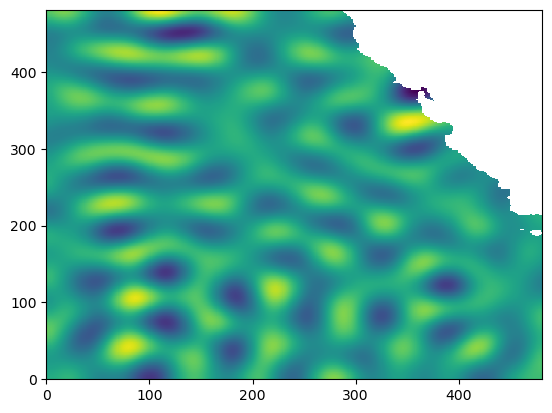

In [22]:
plt.pcolormesh(ssh_it1.values[0])

Variables are renamed : 

In [23]:
ssh_it1 = ssh_it1.rename("ssh_it1")
ssh_it2 = ssh_it2.rename("ssh_it2")
ssh_it3 = ssh_it3.rename("ssh_it2")

Dataset is created : 

In [ ]:
ds_ssh_it = xr.Dataset(data_vars={"ssh_it1" : ssh_it1,
                                  "ssh_it2" : ssh_it2,
                                  "ssh_it3" : ssh_it3,
                                  })
ds_ssh_it.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_it/by_mode/CCS_snapshot.nc")

In [ ]:
ds_ssh_it

## Functions 

In [8]:
def create_cartesian_grid (latitude,longitude,dx):
    """ 
    Creates a cartesian grid (regular in distance, kilometers) from a geodesic latitude, longitude grid. 
    The new grid is expressed in latitude, longitude coordinates.

    Parameters
    ----------
    longitude : numpy ndarray 
        Vector of longitude for geodesic input grid. 
    latitude : numpy ndarray 
        Vector of latitude for geodesic input grid. 
    dx : float 
        Grid spacing in kilometers. 

    Returns
    -------
    ENSLAT2D : 
        2-D numpy ndarray of the latitudes of the points of the cartesian grid 
    ENSLON2D : 
        2-D numpy ndarray of the longitudes of the points of the cartesian grid 
    """
    km2deg = 1/111

    # ENSEMBLE OF LATITUDES # 
    ENSLAT = np.arange(latitude[0],latitude[-1]+dx*km2deg,dx*km2deg)
    range_lon = longitude[-1]-longitude[0]

    if longitude.size%2 == 0 : 
        nstep_lon = floor(range_lon/(dx*km2deg))+2
    else : 
        #nstep_lon = ceil(range_lon/(dx*km2deg))+2
        nstep_lon = ceil(range_lon/(dx*km2deg))+1
    ENSLAT2D = np.repeat(np.expand_dims(ENSLAT,axis=1),axis=1,repeats=nstep_lon)

    # ENSEMBLE OF LATITUDES # 
    mid_lon = (longitude[-1]+longitude[0])/2
    ENSLON2D=np.zeros_like(ENSLAT2D)

    for i in range(len(ENSLAT)):
        d_lon = dx*km2deg*(np.cos(np.pi*ENSLAT[0]/180)/np.cos(np.pi*ENSLAT[i]/180))
        d_lon_range = np.array([i*d_lon for i in range (1,int(nstep_lon/2)+1)])
        lon_left = np.flip(mid_lon-d_lon_range)
        lon_right = mid_lon+d_lon_range
        ENSLON2D[i,:]=np.concatenate((lon_left,lon_right))

    return ENSLAT2D, ENSLON2D, ENSLAT2D.shape[0], ENSLAT2D.shape[1]
    

In [9]:
def bandpass(wavenumbers):
    _bandpass = np.zeros((3*ny,3*nx))
    for i in range(3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]>wavenumbers[0] and wavenum2D[i,j]<wavenumbers[1]:
                _bandpass[i,j] = 1
    return _bandpass

In [10]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [11]:
def apply_filter(ssh_freq,H):
    
    return ssh_filtered

In [12]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [13]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [14]:
def extract_it_mode(ssh0,window,dx):
    
    ssh = extend(ssh0,nx,ny)
    ssh = ssh * window
    ssh_freq = fp.fft2(ssh)
        
    # MODE 1 #
    ssh_freq_filtered_1 = bandpass_mode_1 * ssh_freq
    ssh_filtered_1 = np.real(fp.ifft2(ssh_freq_filtered_1))[ny:2*ny,nx:2*nx]

    # MODE 2 #
    ssh_freq_filtered_2 = bandpass_mode_2 * ssh_freq
    ssh_filtered_2 = np.real(fp.ifft2(ssh_freq_filtered_2))[ny:2*ny,nx:2*nx]

    # MODE 3 #
    ssh_freq_filtered_3 = bandpass_mode_3 * ssh_freq
    ssh_filtered_3 = np.real(fp.ifft2(ssh_freq_filtered_3))[ny:2*ny,nx:2*nx]

    return ssh_filtered_1, ssh_filtered_2, ssh_filtered_3
